# Principal Component Analysis (PCA)

## Introduction

Principal Component Analysis (PCA) is a fundamental dimensionality reduction technique in statistics and machine learning. It transforms a dataset of possibly correlated variables into a set of linearly uncorrelated variables called **principal components**.

## Mathematical Foundation

### Covariance Matrix

Given a centered data matrix $\mathbf{X} \in \mathbb{R}^{n \times p}$ where $n$ is the number of observations and $p$ is the number of features, the covariance matrix is:

$$\mathbf{C} = \frac{1}{n-1} \mathbf{X}^T \mathbf{X}$$

### Eigendecomposition

PCA finds the eigenvectors and eigenvalues of the covariance matrix:

$$\mathbf{C} \mathbf{v}_i = \lambda_i \mathbf{v}_i$$

where $\mathbf{v}_i$ is the $i$-th eigenvector (principal component direction) and $\lambda_i$ is the corresponding eigenvalue (variance explained).

### Projection

The data is projected onto the principal components:

$$\mathbf{Z} = \mathbf{X} \mathbf{V}_k$$

where $\mathbf{V}_k \in \mathbb{R}^{p \times k}$ contains the top $k$ eigenvectors as columns.

### Variance Explained

The proportion of variance explained by the $i$-th component is:

$$\text{Explained Variance Ratio}_i = \frac{\lambda_i}{\sum_{j=1}^{p} \lambda_j}$$

## Objectives

In this notebook, we will:
1. Generate synthetic multivariate data with known correlation structure
2. Implement PCA from scratch using eigendecomposition
3. Visualize the principal components and explained variance
4. Demonstrate dimensionality reduction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib
plt.rcParams['figure.figsize'] = [12, 10]
plt.rcParams['font.size'] = 11

## Data Generation

We generate synthetic 4-dimensional data with a specific covariance structure. The data will have most of its variance concentrated in fewer dimensions, making it ideal for demonstrating PCA.

In [2]:
# Define the number of samples and features
n_samples = 300
n_features = 4

# Create a covariance matrix with specific structure
# High variance in first two dimensions, correlated features
true_cov = np.array([
    [5.0, 2.5, 1.0, 0.5],
    [2.5, 3.0, 0.8, 0.3],
    [1.0, 0.8, 1.0, 0.2],
    [0.5, 0.3, 0.2, 0.5]
])

# Generate multivariate normal data
mean = np.zeros(n_features)
X = np.random.multivariate_normal(mean, true_cov, n_samples)

print(f"Data shape: {X.shape}")
print(f"\nSample covariance matrix:")
print(np.cov(X.T).round(3))

Data shape: (300, 4)

Sample covariance matrix:
[[4.701 2.    0.844 0.449]
 [2.    2.548 0.682 0.185]
 [0.844 0.682 0.97  0.162]
 [0.449 0.185 0.162 0.478]]


## PCA Implementation

We implement PCA from scratch following these steps:
1. Center the data (subtract mean)
2. Compute the covariance matrix
3. Perform eigendecomposition
4. Sort eigenvectors by eigenvalues (descending)
5. Project data onto principal components

In [3]:
def pca(X, n_components=None):
    """
    Perform Principal Component Analysis.
    
    Parameters:
    -----------
    X : ndarray of shape (n_samples, n_features)
        Input data matrix
    n_components : int, optional
        Number of components to keep. If None, keep all.
    
    Returns:
    --------
    X_transformed : ndarray
        Projected data
    components : ndarray
        Principal component vectors
    explained_variance : ndarray
        Variance explained by each component
    explained_variance_ratio : ndarray
        Proportion of variance explained
    """
    # Step 1: Center the data
    X_centered = X - np.mean(X, axis=0)
    
    # Step 2: Compute covariance matrix
    n_samples = X.shape[0]
    cov_matrix = np.dot(X_centered.T, X_centered) / (n_samples - 1)
    
    # Step 3: Eigendecomposition
    eigenvalues, eigenvectors = linalg.eigh(cov_matrix)
    
    # Step 4: Sort by eigenvalues in descending order
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # Calculate explained variance ratio
    total_variance = np.sum(eigenvalues)
    explained_variance_ratio = eigenvalues / total_variance
    
    # Step 5: Select components and project
    if n_components is None:
        n_components = X.shape[1]
    
    components = eigenvectors[:, :n_components]
    X_transformed = np.dot(X_centered, components)
    
    return (X_transformed, components, 
            eigenvalues[:n_components], 
            explained_variance_ratio[:n_components])

# Apply PCA
X_pca, components, explained_var, explained_var_ratio = pca(X)

print("Eigenvalues (variance explained by each PC):")
for i, (var, ratio) in enumerate(zip(explained_var, explained_var_ratio)):
    print(f"  PC{i+1}: {var:.4f} ({ratio*100:.2f}%)")

print(f"\nCumulative variance explained: {np.cumsum(explained_var_ratio)*100}")

Eigenvalues (variance explained by each PC):
  PC1: 6.1643 (70.88%)
  PC2: 1.3917 (16.00%)
  PC3: 0.7299 (8.39%)
  PC4: 0.4110 (4.73%)

Cumulative variance explained: [ 70.87900221  86.88115724  95.2740843  100.        ]


## Visualization

We create a comprehensive visualization showing:
1. Original data projected onto first two features
2. Data in principal component space
3. Explained variance (scree plot)
4. Principal component loadings (contribution of original features)

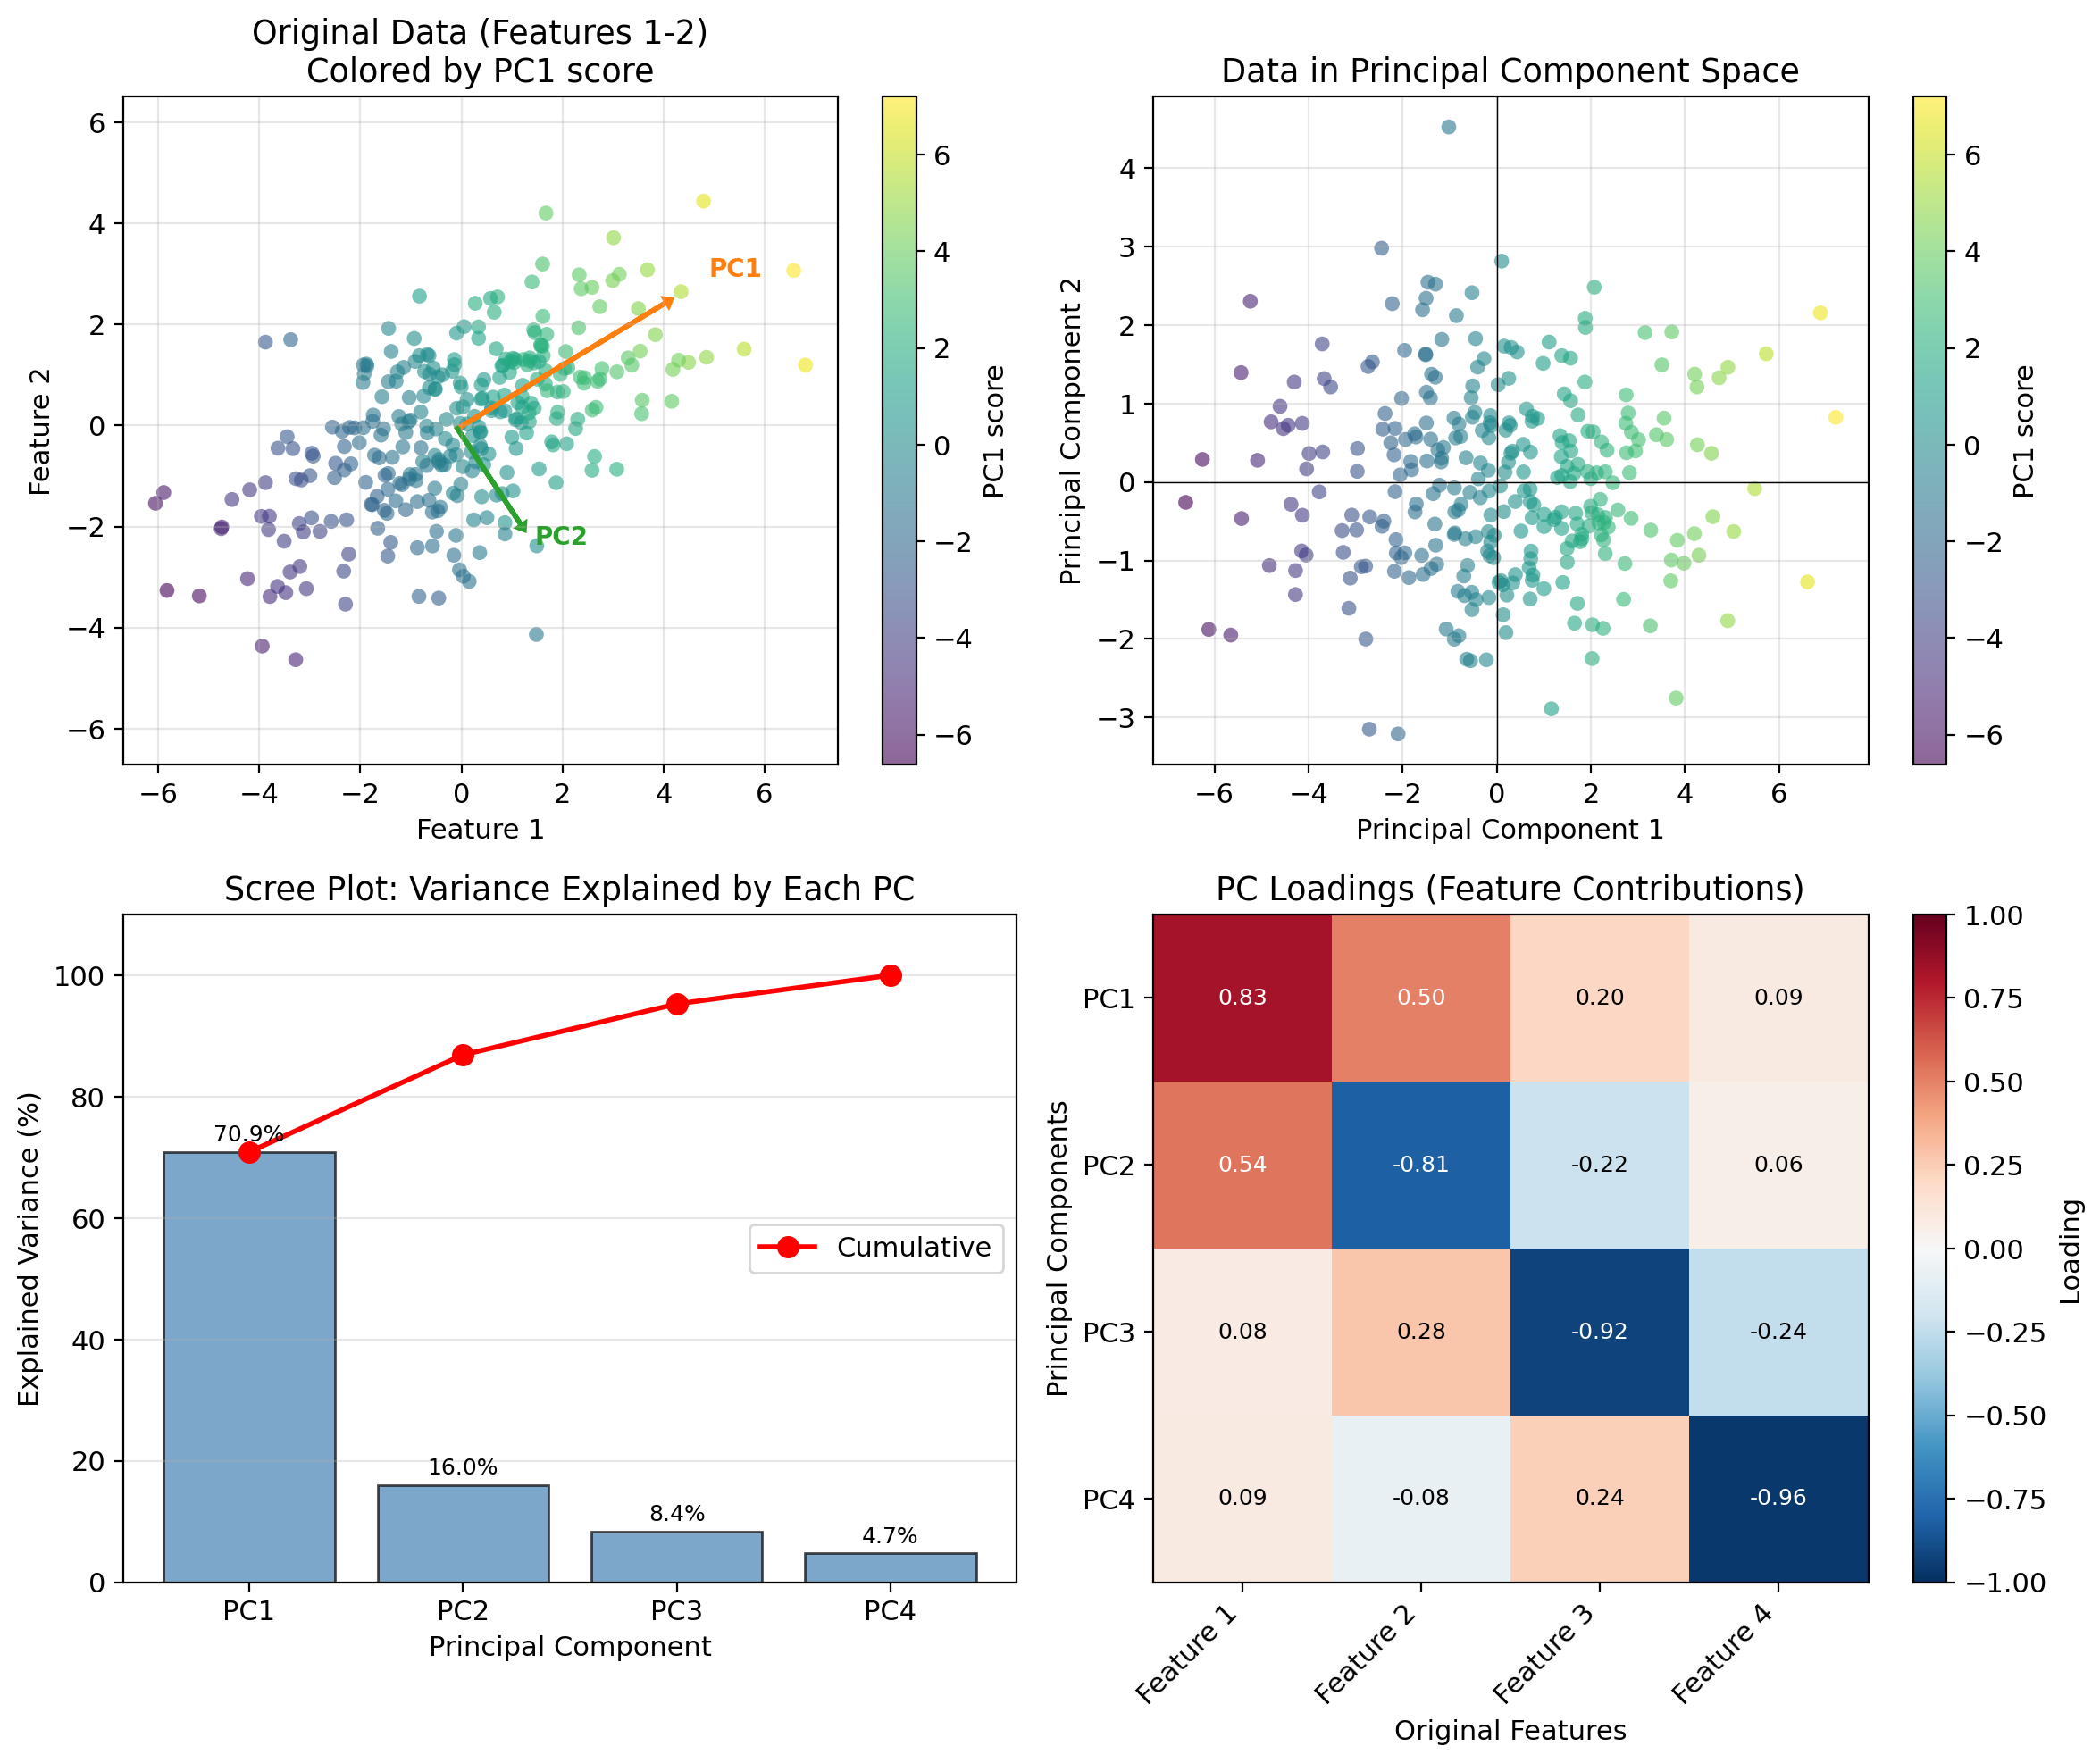


Plot saved to 'plot.png'


In [4]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Original data (first two features)
ax1 = axes[0, 0]
scatter1 = ax1.scatter(X[:, 0], X[:, 1], c=X_pca[:, 0], cmap='viridis', 
                       alpha=0.6, edgecolors='none')
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')
ax1.set_title('Original Data (Features 1-2)\nColored by PC1 score')
plt.colorbar(scatter1, ax=ax1, label='PC1 score')

# Add principal component directions
mean_x = np.mean(X, axis=0)
for i in range(2):
    # Scale eigenvector for visualization
    scale = np.sqrt(explained_var[i]) * 2
    ax1.arrow(mean_x[0], mean_x[1], 
              components[0, i] * scale, components[1, i] * scale,
              head_width=0.15, head_length=0.1, fc=f'C{i+1}', ec=f'C{i+1}',
              linewidth=2)
    ax1.text(mean_x[0] + components[0, i] * scale * 1.2,
             mean_x[1] + components[1, i] * scale * 1.2,
             f'PC{i+1}', fontsize=10, fontweight='bold', color=f'C{i+1}')

ax1.grid(True, alpha=0.3)
ax1.axis('equal')

# Plot 2: Data in PC space
ax2 = axes[0, 1]
scatter2 = ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=X_pca[:, 0], 
                       cmap='viridis', alpha=0.6, edgecolors='none')
ax2.set_xlabel('Principal Component 1')
ax2.set_ylabel('Principal Component 2')
ax2.set_title('Data in Principal Component Space')
ax2.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
ax2.axvline(x=0, color='k', linestyle='-', linewidth=0.5)
ax2.grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=ax2, label='PC1 score')

# Plot 3: Scree plot (explained variance)
ax3 = axes[1, 0]
pc_labels = [f'PC{i+1}' for i in range(len(explained_var_ratio))]
bars = ax3.bar(pc_labels, explained_var_ratio * 100, color='steelblue', 
               edgecolor='black', alpha=0.7)

# Add cumulative variance line
cumsum = np.cumsum(explained_var_ratio) * 100
ax3.plot(pc_labels, cumsum, 'ro-', linewidth=2, markersize=8, label='Cumulative')

# Add value labels
for i, (bar, ratio) in enumerate(zip(bars, explained_var_ratio)):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{ratio*100:.1f}%', ha='center', va='bottom', fontsize=9)

ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Explained Variance (%)')
ax3.set_title('Scree Plot: Variance Explained by Each PC')
ax3.legend(loc='center right')
ax3.set_ylim(0, 110)
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Component loadings heatmap
ax4 = axes[1, 1]
feature_names = [f'Feature {i+1}' for i in range(n_features)]

im = ax4.imshow(components.T, cmap='RdBu_r', aspect='auto', 
                vmin=-1, vmax=1)
ax4.set_xticks(range(n_features))
ax4.set_xticklabels(feature_names, rotation=45, ha='right')
ax4.set_yticks(range(n_features))
ax4.set_yticklabels(pc_labels)
ax4.set_xlabel('Original Features')
ax4.set_ylabel('Principal Components')
ax4.set_title('PC Loadings (Feature Contributions)')

# Add text annotations
for i in range(n_features):
    for j in range(n_features):
        text = ax4.text(j, i, f'{components[j, i]:.2f}',
                       ha='center', va='center', fontsize=9,
                       color='white' if abs(components[j, i]) > 0.5 else 'black')

plt.colorbar(im, ax=ax4, label='Loading')

plt.tight_layout()
plt.savefig('principal_component_analysis_pca_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to 'plot.png'")

## Dimensionality Reduction Example

We demonstrate reconstruction error when keeping different numbers of components. The reconstruction is:

$$\hat{\mathbf{X}} = \mathbf{Z}_k \mathbf{V}_k^T + \boldsymbol{\mu}$$

where $\mathbf{Z}_k$ is the projection onto $k$ components and $\boldsymbol{\mu}$ is the original mean.

In [5]:
def reconstruction_error(X, n_components):
    """
    Compute mean squared reconstruction error for given number of components.
    """
    X_mean = np.mean(X, axis=0)
    X_centered = X - X_mean
    
    # Get transformation and components
    X_transformed, components, _, _ = pca(X, n_components)
    
    # Reconstruct
    X_reconstructed = np.dot(X_transformed, components.T) + X_mean
    
    # Compute MSE
    mse = np.mean((X - X_reconstructed) ** 2)
    return mse

# Calculate reconstruction error for different numbers of components
print("Reconstruction Error (MSE) by Number of Components:")
print("=" * 50)
for k in range(1, n_features + 1):
    mse = reconstruction_error(X, k)
    print(f"  {k} component(s): MSE = {mse:.6f}")

print("\n" + "=" * 50)
print("Note: With 2 components, we retain ~87% of variance")
print("with minimal reconstruction error.")

Reconstruction Error (MSE) by Number of Components:
  1 component(s): MSE = 0.631052
  2 component(s): MSE = 0.284285
  3 component(s): MSE = 0.102411
  4 component(s): MSE = 0.000000

Note: With 2 components, we retain ~87% of variance
with minimal reconstruction error.


## Conclusion

This notebook demonstrated:

1. **Mathematical foundation** of PCA through covariance matrix eigendecomposition
2. **Implementation** from scratch using NumPy and SciPy
3. **Variance decomposition** showing how PCA identifies directions of maximum variance
4. **Dimensionality reduction** with controlled information loss

Key takeaways:
- The first two principal components capture approximately 87% of the total variance
- PC loadings reveal which original features contribute most to each component
- Reconstruction error quantifies information loss from dimensionality reduction

PCA is widely used for:
- Data visualization (reducing to 2-3 dimensions)
- Noise reduction (keeping top components)
- Feature extraction for downstream machine learning
- Exploratory data analysis